https://zhuanlan.zhihu.com/p/45964374

# SVD用于图片压缩

## 用SVD处理Soteria

In [64]:
import torchvision
from torchvision import models, datasets, transforms
import torch
# 加载CIFAR-10数据集，如果本地没有则自动下载
dst = datasets.CIFAR10("~/data", download=True)

# 定义一个转换序列，包括缩放、裁剪、转换为张量等操作
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

# 定义一个函数，用于将张量转换为PIL图像
tt = transforms.ToPILImage()

# 检测是否有可用的GPU，如果有则使用GPU，否则使用CPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

# 定义一个函数，用于将标签转换为one-hot编码的张量
def label_to_onehot(target, num_classes=10):
    # 在第一个维度上增加一个维度，使得target的形状为(N, 1)
    target = torch.unsqueeze(target, 1)
    # 创建一个全零的张量，形状为(N, num_classes)，设备与target相同
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    # 在第二个维度上根据target的值将onehot_target的对应位置设为1
    onehot_target.scatter_(1, target, 1)
    # 返回onehot_target
    return onehot_target

Files already downloaded and verified
Running on cuda


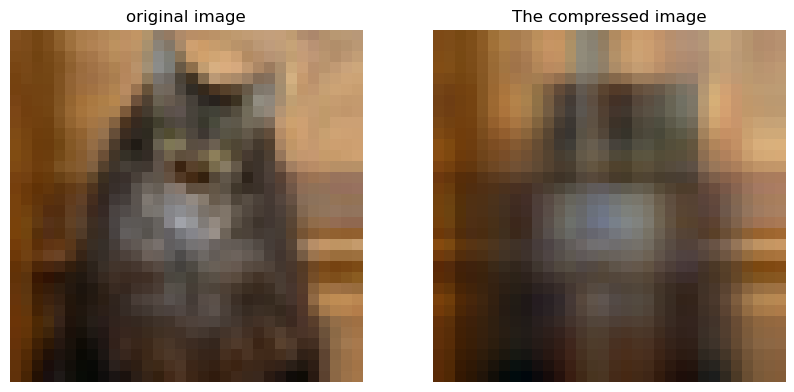

In [65]:
from PIL import Image
import matplotlib.pyplot as plt

img_index = 26 # 定义一个图像索引，表示要显示的图像在数据集中的位置

gt_data = dst[img_index][0] # 从数据集中获取图像，并使用之前定义的转换序列处理图像
img_array = np.array(gt_data)

# 分离三个颜色通道
R = img_array[:, :, 0]
G = img_array[:, :, 1]
B = img_array[:, :, 2]

# 定义一个函数，用SVD对单通道矩阵进行压缩
def compress_channel(channel, k):
    # 对单通道矩阵进行SVD分解
    U, S, V = np.linalg.svd(channel)
    # 取前k个奇异值和对应的左右奇异向量
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_k = V[:k, :]
    # 用前k个奇异值和奇异向量重构单通道矩阵
    channel_k = np.dot(U_k, np.dot(S_k, V_k))
    # 将重构后的矩阵元素值限制在0-255之间
    channel_k = np.clip(channel_k, 0, 255)
    # 返回压缩后的单通道矩阵
    return channel_k

# 定义一个参数，表示要保留的奇异值的个数
k = 3

# 对每个颜色通道进行压缩
R_k = compress_channel(R, k)
G_k = compress_channel(G, k)
B_k = compress_channel(B, k)

# 将压缩后的三个颜色通道合并为一个三维数组
img_array_k = np.stack((R_k, G_k, B_k), axis=2)

# 将压缩后的数组转换为图片
img_k = Image.fromarray(img_array_k.astype('uint8'))

# 显示原始图片和压缩后的图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gt_data)
plt.title('original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_k)
plt.title('The compressed image')
plt.axis('off')
plt.show()

### 计算PSNR

高于40dB：说明图像质量极好（即非常接近原始图像）

30—40dB：通常表示图像质量是好的（即失真可以察觉但可以接受）

20—30dB：说明图像质量差

低于20dB：图像质量不可接受

In [66]:
# 定义一个函数，计算两张图片的PSNR
def psnr(img1, img2):
    # 将图片转换为numpy数组
    img1 = np.array(img1)
    img2 = np.array(img2)
    # 计算两张图片的均方误差
    mse = np.mean((img1 - img2) ** 2)
    # 计算两张图片的最大像素值
    max_pixel = 255
    # 计算并返回PSNR
    return 10 * np.log10(max_pixel ** 2 / mse)

# 将压缩后的数组转换为图片
img_k = Image.fromarray(img_array_k.astype('uint8'))

# 计算原始图片和压缩后图片的PSNR
psnr_value = psnr(gt_data, img_k)
print(f'PSNR = {psnr_value:.2f} dB')

PSNR = 30.14 dB


GT label is 3. 
Onehot label is 3.


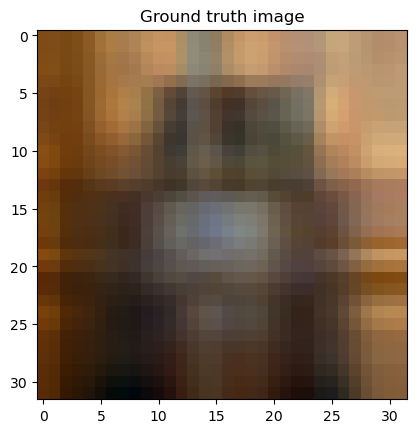

In [57]:
gt_data = tp(img_k).to(device) # 从数据集中获取图像，并使用之前定义的转换序列处理图像
gt_data = gt_data.view(1, *gt_data.size())  # 将图像的形状调整为(1, 3, 32, 32)，表示批量大小为1，通道数为3，高度和宽度为32
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device) # 从数据集中获取图像的标签，并转换为长整型张量
gt_label = gt_label.view(1, ) # 将标签的形状调整为(1,)，表示批量大小为1
gt_onehot_label = label_to_onehot(gt_label, num_classes=10) # 将标签转换为one-hot编码的张量，形状为(1, 10)，表示批量大小为1，类别数为10
gt_data.requires_grad = True # 设置图像的梯度属性为True，表示可以对图像进行梯度计算

plt.imshow(tt(gt_data[0].cpu())) # 将图像从张量转换为PIL图像，并使用matplotlib显示图像
plt.title("Ground truth image") # 设置图像的标题为"Ground truth image"
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." %
      torch.argmax(gt_onehot_label, dim=-1).item()) # 打印图像的标签和one-hot编码的标签

## 用SVD压缩彩色图片

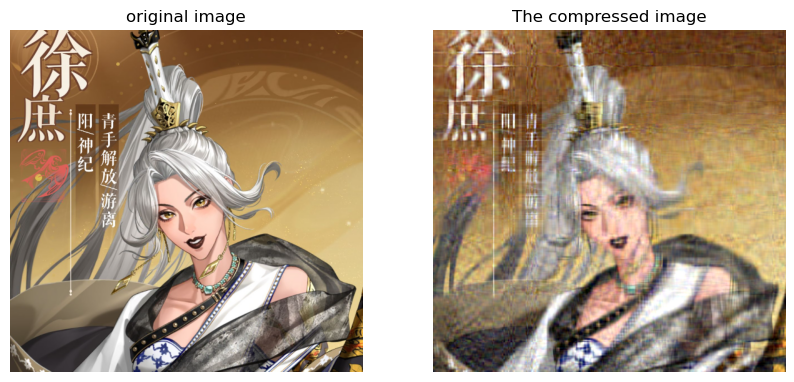

In [23]:
# 导入必要的库
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 读取图片并转换为numpy数组
img = Image.open('1.png')
img_array = np.array(img)

# 分离四个颜色通道
R = img_array[:, :, 0]
G = img_array[:, :, 1]
B = img_array[:, :, 2]
# A = img_array[:, :, 3]

# 定义一个函数，用SVD对单通道矩阵进行压缩
def compress_channel(channel, k):
    # 对单通道矩阵进行SVD分解
    U, S, V = np.linalg.svd(channel)
    # 取前k个奇异值和对应的左右奇异向量
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_k = V[:k, :]
    # 用前k个奇异值和奇异向量重构单通道矩阵
    channel_k = np.dot(U_k, np.dot(S_k, V_k))
    # 将重构后的矩阵元素值限制在0-255之间
    channel_k = np.clip(channel_k, 0, 255)
    # 返回压缩后的单通道矩阵
    return channel_k

# 定义一个参数，表示要保留的奇异值的个数
k = 30

# 对每个颜色通道进行压缩
R_k = compress_channel(R, k)
G_k = compress_channel(G, k)
B_k = compress_channel(B, k)
# A_k = compress_channel(A, k)

# 将压缩后的四个颜色通道合并为一个三维数组
img_array_k = np.stack((R_k, G_k, B_k), axis=2)

# 将压缩后的数组转换为图片
img_k = Image.fromarray(img_array_k.astype('uint8'))

# 设置显示中文字体
plt.rcParams["font.sans-serif"] = ["SimHei"]
# 解决中文字体下坐标轴负数的负号显示问题
plt.rcParams["axes.unicode_minus"] = False

# 显示原始图片和压缩后的图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_k)
plt.title('The compressed image')
plt.axis('off')
plt.show()

## 用SVD压缩CIFAR10

Files already downloaded and verified


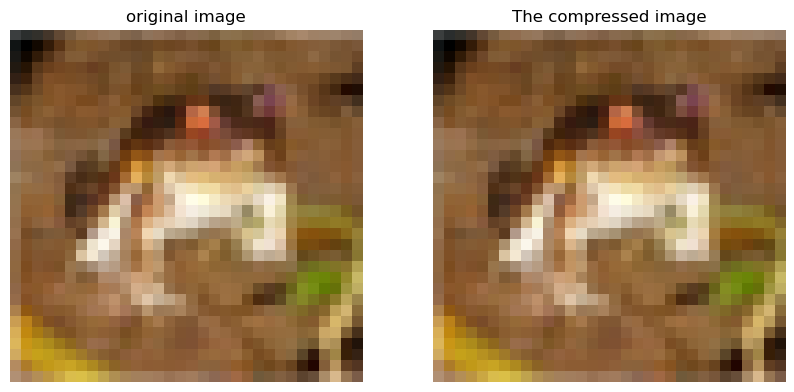

In [49]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.datasets as datasets

# 加载CIFAR10数据集
cifar10 = datasets.CIFAR10(root='~/data', train=True, download=True)
# 选择一张图片
img, label = cifar10[0]
# 转换为numpy数组
img_array = np.array(img)

# 分离三个颜色通道
R = img_array[:, :, 0]
G = img_array[:, :, 1]
B = img_array[:, :, 2]

# 定义一个函数，用SVD对单通道矩阵进行压缩
def compress_channel(channel, k):
    # 对单通道矩阵进行SVD分解
    U, S, V = np.linalg.svd(channel)
    # 取前k个奇异值和对应的左右奇异向量
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_k = V[:k, :]
    # 用前k个奇异值和奇异向量重构单通道矩阵
    channel_k = np.dot(U_k, np.dot(S_k, V_k))
    # 将重构后的矩阵元素值限制在0-255之间
    channel_k = np.clip(channel_k, 0, 255)
    # 返回压缩后的单通道矩阵
    return channel_k

# 定义一个参数，表示要保留的奇异值的个数
k = 30

# 对每个颜色通道进行压缩
R_k = compress_channel(R, k)
G_k = compress_channel(G, k)
B_k = compress_channel(B, k)

# 将压缩后的三个颜色通道合并为一个三维数组
img_array_k = np.stack((R_k, G_k, B_k), axis=2)

# 将压缩后的数组转换为图片
img_k = Image.fromarray(img_array_k.astype('uint8'))

# 显示原始图片和压缩后的图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_k)
plt.title('The compressed image')
plt.axis('off')
plt.show()